<a href="https://colab.research.google.com/github/rohit112121/Healthcare-Fraud-Detection/blob/main/healthcare_FRAUD_using%20ML%20and%20DL%20Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'healthcare-provider-fraud-detection-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F188596%2F421248%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240917%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240917T131341Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D716839dc4fe03538931e883754effabc7af99f7108ba96b6b95d0d875f9f503f56bb52e57e677a75a33092fa35178f4e9fa14c5b190cd603422f19cba5e1152cd7ce02213dbaba773b8a866ad9d6d91cb5bce2efa801ee1d48b3c1186c2e1fb8048a80d28f22c77d202cd009fe29e56e6e324a1bb2a5e9b6abf9ed5dc6fa0775d672060ce43ebba77e36cf72698b671f5bb2bfed41506e22e4ca0094cc33fcd445e47dc19519397612419910f38670374e3c1726e3a06eb80bf4fbb06bbc68502db1bc8819dd2556a1eafd9d6614daa864e19a666066526f96772071a3e3ca0938fe179899ec9eb821af14fb17000227d1ff37a5efbb1d5745ef8fcaeffc6810'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26631783 bytes downloaded
Downloaded and uncompressed: healthcare-provider-fraud-detection-analysis
Data source import complete.


In [3]:
!pip install imbalanced-learn

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder , LabelEncoder
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [5]:
Train=pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv("../input/healthcare-provider-fraud-detection-analysis/Train_Outpatientdata-1542865627584.csv")

# Merging data

In [6]:
Train_Allpatientdata=pd.merge(Train_Outpatientdata,Train_Inpatientdata,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

In [7]:
Train_Allpatientdata=pd.merge(Train_Allpatientdata,Train_Beneficiarydata,on="BeneID")

In [8]:
Train_Allpatientdata=pd.merge(Train_Allpatientdata,Train,on="Provider")

In [9]:
Train_Allpatientdata.shape

(558211, 55)

In [18]:
Train_Allpatientdata.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,2,0,0,30,50,Yes
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,1,2,0,0,1810,760,Yes
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,1,2,0,0,1810,760,Yes
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,1,2,0,0,1810,760,Yes
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,1,2,0,0,1810,760,Yes


In [19]:
Train_Allpatientdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   ClmDiagnosisCode_1               547758 non-null  object 
 10  ClmDiagnosisCode_2               362605 non-null  object 
 11  ClmDiagnosisCode_3               243055 non-null  object 
 12  Cl

# Physician cols preprocessing

In [10]:
a=(Train_Allpatientdata["AttendingPhysician"]==Train_Allpatientdata["OperatingPhysician"])
b=(Train_Allpatientdata["OperatingPhysician"]==Train_Allpatientdata["OtherPhysician"])
c=(Train_Allpatientdata["AttendingPhysician"]==Train_Allpatientdata["OtherPhysician"])

print(a.sum())
print(b.sum())
print(c.sum())
print( (a+b).sum() ) # atten=oper=other

61164
15884
85258
63872


In [11]:
def physician_same(row):
    atten_oper=row["AttendingPhysician"]==row["OperatingPhysician"]
    oper_other=row["OperatingPhysician"]==row["OtherPhysician"]
    atten_other=row["AttendingPhysician"]==row["OtherPhysician"]
    if atten_oper==True and oper_other==True:# atten = oper = other
        return 0
    elif atten_oper==True and oper_other==False:# atten = oper != other
        return 1
    elif atten_oper==False and oper_other==True:# atten != oper = other
        return 2
    else:# atten != oper != other
        return 3

phy_same=Train_Allpatientdata.apply(physician_same,axis=1)

In [12]:
Train_Allpatientdata["phy_same"]=phy_same

In [13]:
def physician_count(row,list_count):
    count=0
    for col in list_count:
        if pd.isnull(row[col]):
            continue
        else:
            count+=1
    return count

list_count=["AttendingPhysician","OperatingPhysician","OtherPhysician"]
phy_count=Train_Allpatientdata.apply(physician_count,axis=1,args=(list_count,))

In [14]:
Train_Allpatientdata["phy_count"]=phy_count

In [15]:
Train_Allpatientdata.head(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,phy_same,phy_count
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,0,0,30,50,Yes,3,1
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,2,0,0,1810,760,Yes,3,1
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,2,0,0,1810,760,Yes,3,1
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,2,0,0,1810,760,Yes,3,1


# ClainStartDt , ClainEndDt cols preprocessing

In [16]:
startdate= pd.to_datetime( Train_Allpatientdata["ClaimStartDt"] )
enddate= pd.to_datetime( Train_Allpatientdata["ClaimEndDt"] )

period = ( enddate - startdate).dt.days
Train_Allpatientdata["period"] = period

In [17]:
Train_Allpatientdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 58 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   ClmDiagnosisCode_1               547758 non-null  object 
 10  ClmDiagnosisCode_2               362605 non-null  object 
 11  ClmDiagnosisCode_3               243055 non-null  object 
 12  Cl

## taking copy

In [18]:
copy1=Train_Allpatientdata.copy()

# Cronic code cols preprocessing

In [19]:
cronic_cols_names=copy1.columns[ copy1.columns.str.startswith("ChronicCond") ]
cronic_cols=copy1[   cronic_cols_names   ]
cronic=cronic_cols.replace({2:0})
copy1[   cronic_cols_names   ]=cronic

# Potintial fraud preprocessing

In [20]:
copy1["PotentialFraud"]=copy1["PotentialFraud"].replace({"Yes":1,"No":0})

# gender preprocessing

In [21]:
copy1["Gender"]=copy1["Gender"].replace({2:0})

# Admisson data preprocessing

In [22]:
startadmt= pd.to_datetime( copy1["AdmissionDt"] )
enddatadmt= pd.to_datetime( copy1["DischargeDt"] )

periodadmt = ( enddatadmt - startadmt).dt.days
copy1["periodadmt"] = periodadmt
copy1["periodadmt"]=copy1["periodadmt"].fillna(0)

# RenalDiseaseIndicator preprocessing

In [23]:
copy1["RenalDiseaseIndicator"]=copy1["RenalDiseaseIndicator"].replace({"Y":1})

# patient age preprocessing

In [24]:
birthdate=pd.to_datetime(copy1["DOB"])
enddate=pd.to_datetime(copy1["DOD"])

# cheack whether the patient dead or alife
def alife_function(value):
    if value==True:
        return 1
    else:
        return 0
alife = pd.isna(enddate).apply(alife_function)


# get the age of patient
max_date=enddate.dropna().max()
enddate[pd.isna(enddate)]=max_date
period=(((enddate-birthdate).dt.days/356).astype(int))

copy1["age"]=period
copy1["alife"]=alife

In [25]:
copy1.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,phy_same,phy_count,period,periodadmt,age,alife
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,30,50,1,3,1,0,0.0,75,1
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0,1810,760,1,3,1,0,0.0,89,1


In [36]:
copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 61 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   ClmDiagnosisCode_1               547758 non-null  object 
 10  ClmDiagnosisCode_2               362605 non-null  object 
 11  ClmDiagnosisCode_3               243055 non-null  object 
 12  Cl

# means and stds

In [26]:
def groupby(df,by,vars_to_group,methods,col_ident,as_index=True,agg=False):
    if agg:
        grouped=df.groupby(by=by,as_index=as_index)[vars_to_group].agg(methods)
        cols=['_'.join(col) for col in grouped.columns.values]
        cols=[col_ident+"_"+col for col in cols]
        grouped.columns=cols
        return grouped

    else:
        concat=df.groupby(by=by,as_index=as_index)[vars_to_group].transform(methods[0])
        cols=[ col_ident+"_"+col+"_"+methods[0] for col in concat.columns ]
        concat.columns=cols

        for method in methods[1:]:
            grouped=df.groupby(by=by,as_index=as_index)[vars_to_group].transform(method)
            cols=[col_ident+"_"+col+"_"+method for col in grouped.columns]
            grouped.columns=cols
            concat=pd.concat([concat,grouped],axis=1)

        return concat

In [27]:
money_cols=["InscClaimAmtReimbursed","DeductibleAmtPaid","NoOfMonths_PartACov","NoOfMonths_PartBCov",
           "IPAnnualReimbursementAmt","IPAnnualDeductibleAmt","OPAnnualReimbursementAmt","OPAnnualDeductibleAmt"]

calculate the mean and standard deviation of monetary values for each healthcare provider.

In [32]:
provider_money=groupby(copy1,["Provider"],money_cols,["mean","std"],"provider",
                       True,False)

In [29]:
banel_money=groupby(copy1,["BeneID"],money_cols,["mean","std"],"banel",
                       True,False)
#This DataFrame provides insights into the average and variability of monetary values associated with each beneficiary.

In [33]:
diag1_money=groupby(copy1,["ClmDiagnosisCode_1"],money_cols,["mean","std"],"diag1",
                       True,False)
#This DataFrame provides insights into the average and variability of monetary values associated with each primary diagnosis code

In [34]:
selected_cols_names=["phy_same","phy_count","period","periodadmt","age","alife","Provider","PotentialFraud"]
selected_cols=copy1[selected_cols_names]
#This code snippet selects a subset of columns from the copy1 DataFrame and assigns them to a new DataFrame called selected_cols.

In [35]:
data=pd.concat([selected_cols,provider_money,banel_money,diag1_money],axis=1)
#This code snippet combines multiple DataFrames (selected_cols, provider_money, banel_money, and diag1_money) horizontally (column-wise) using pd.concat to create a new DataFrame called data.

In [37]:
grouped=data.groupby(by=["Provider","PotentialFraud"]).agg("mean").reset_index()
#This code snippet groups the data DataFrame by "Provider" and "PotentialFraud" and calculates the mean of all numerical columns for each group.

In [38]:
grouped

,Provider,PotentialFraud,phy_same,phy_count,period,periodadmt,age,alife,provider_InscClaimAmtReimbursed_mean,provider_DeductibleAmtPaid_mean,...,diag1_OPAnnualReimbursementAmt_mean,diag1_OPAnnualDeductibleAmt_mean,diag1_InscClaimAmtReimbursed_std,diag1_DeductibleAmtPaid_std,diag1_NoOfMonths_PartACov_std,diag1_NoOfMonths_PartBCov_std,diag1_IPAnnualReimbursementAmt_std,diag1_IPAnnualDeductibleAmt_std,diag1_OPAnnualReimbursementAmt_std,diag1_OPAnnualDeductibleAmt_std
0,PRV51001,0,2.960000,1.600000,1.440000,1.000000,80.240000,1.000000,4185.600000,213.600000,...,1804.331094,543.045084,3482.066310,161.353027,0.569945,0.424192,12941.552352,1205.297144,2450.076771,661.506672
1,PRV51003,1,2.439394,1.530303,3.674242,2.424242,71.371212,0.992424,4588.409091,502.166667,...,2422.458599,676.313985,4017.871066,260.257069,0.726572,0.653285,12620.604411,1226.306633,3369.338617,848.213675
2,PRV51004,0,2.818792,1.604027,1.429530,0.000000,73.516779,0.993289,350.134228,2.080537,...,2430.017927,694.246881,1536.290845,113.086257,0.667719,0.577420,11016.516937,1111.592405,2972.377916,808.138208
3,PRV51005,1,2.731330,1.599142,1.088412,0.000000,71.783691,0.996567,241.124464,3.175966,...,2195.953526,630.805985,1234.005090,91.141252,0.657071,0.565930,10021.329572,957.701391,2727.944083,737.419878
4,PRV51007,0,2.736111,1.527778,0.958333,0.222222,70.583333,0.986111,468.194444,45.333333,...,2089.969651,606.550334,1519.425993,103.302166,0.626542,0.520122,10565.761429,1126.358206,2486.827069,682.279276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,2.892857,1.464286,2.142857,0.000000,75.285714,1.000000,380.000000,4.642857,...,2770.995487,762.684094,924.661538,88.673186,0.717266,0.575517,11706.835391,989.925167,3092.516228,805.101036
5406,PRV57760,0,2.318182,1.681818,0.318182,0.000000,62.318182,1.000000,216.818182,0.000000,...,1857.020747,551.812490,1182.800362,63.746284,0.738778,0.632455,10087.266945,852.726747,2325.052621,667.813928
5407,PRV57761,0,3.000000,1.609756,1.390244,0.000000,73.268293,0.987805,225.243902,4.512195,...,2409.246660,667.100333,1469.587798,89.369298,0.626573,0.503166,9701.587916,956.791480,2864.403847,730.914731
5408,PRV57762,0,3.000000,1.000000,0.000000,0.000000,69.000000,1.000000,1900.000000,0.000000,...,2332.103825,701.530055,926.436661,146.810805,0.939796,0.000000,10836.121659,798.136760,2327.892739,625.238022


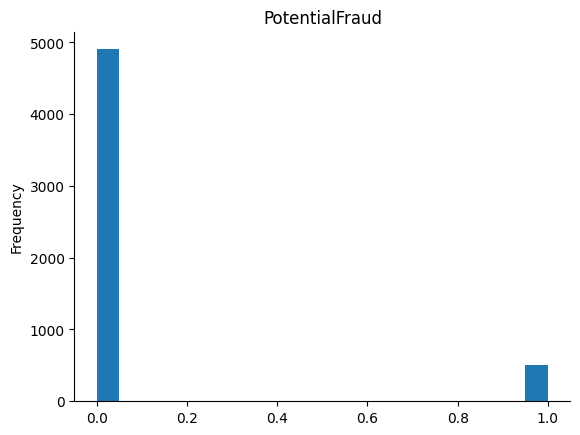

In [39]:
from matplotlib import pyplot as plt
grouped['PotentialFraud'].plot(kind='hist', bins=20, title='PotentialFraud') # Use the 'grouped' DataFrame instead of '_df_0'
plt.gca().spines[['top', 'right',]].set_visible(False)

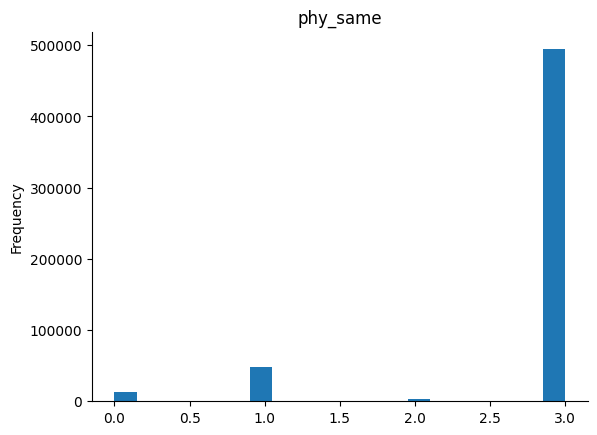

In [40]:
from matplotlib import pyplot as plt

# Create a DataFrame with the 'phy_same' data
df = pd.DataFrame({'phy_same': phy_same}) # Use the existing 'phy_same' Series

df['phy_same'].plot(kind='hist', bins=20, title='phy_same')
plt.gca().spines[['top', 'right',]].set_visible(False)

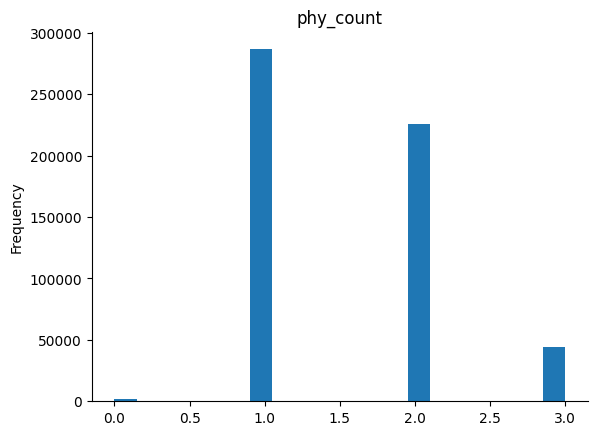

In [41]:
from matplotlib import pyplot as plt

# Create a DataFrame with the 'phy_count' data
df = pd.DataFrame({'phy_count': phy_count}) # Use the existing 'phy_count' Series

df['phy_count'].plot(kind='hist', bins=20, title='phy_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

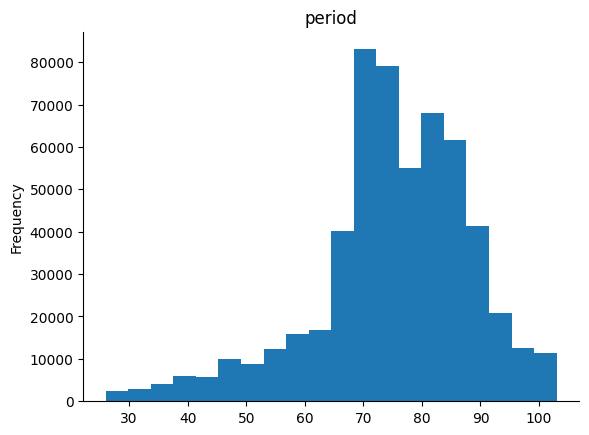

In [42]:
from matplotlib import pyplot as plt
period.plot(kind='hist', bins=20, title='period') # Use the 'period' Series directly
plt.gca().spines[['top', 'right',]].set_visible(False)

In [51]:
grouped=grouped.fillna(0)


1. High Cardinality:

If you have a large number of unique providers, directly using Provider as a categorical feature can lead to high cardinality. This can cause issues in some machine learning models, leading to overfitting or slow training.
2. Lack of Direct Predictive Power:

The Provider ID itself might not be directly predictive of fraud. It's the characteristics of the provider (e.g., average claim amount, types of claims submitted) that are more likely to be informative.
3. Alternative Representations:

The code you've shown uses groupby to create aggregated features based on Provider. This is one way to incorporate information about providers without using the raw ID. These aggregated features (e.g., provider_InscClaimAmtReimbursed_mean) capture the behavior and patterns associated with each provider.
How to potentially include provider information as features:

Target Encoding: Replace each Provider ID with the average fraud rate for that provider. This captures the historical fraud association with each provider.
Frequency Encoding: Replace each Provider ID with the number of times it appears in the dataset. This can capture how common or rare a provider is.
Embedding: If you're using deep learning models, you can learn embeddings for providers, which represent them as dense vectors.
Clustering: Group similar providers based on their aggregated features and use the cluster assignments as a new categorical feature.
Important: If you choose to include Provider or related features, be mindful of potential biases and data leakage, especially if you're doing any time-based analysis or prediction.

In [52]:
features=grouped.iloc[:,2:]
labels=grouped.iloc[:,1]

In [53]:
from collections import Counter

print(Counter(labels))

Counter({0: 4904, 1: 506})


In [63]:
# Impute NaN values using SimpleImputer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

imputer = SimpleImputer(strategy='mean') # or other strategies like 'median', 'most_frequent'
features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Use SMOTEENN instead of SMOTE
from imblearn.combine import SMOTEENN

oversample = SMOTEENN() # Use SMOTEENN instead of SMOTE
features, labels = oversample.fit_resample(features, labels)

In [113]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# features, labels = oversample.fit_resample(features, labels)

In [69]:
from collections import Counter

print(Counter(labels))

Counter({1: 4809, 0: 4617})


In [70]:
scaler = StandardScaler()
featuresstand=scaler.fit_transform(features)
#This code snippet performs standardization on the features data using StandardScaler from scikit-learn.

In [71]:
ff=compute_class_weight(class_weight="balanced",classes=np.unique(labels),y=labels)
cw=dict(zip(np.unique(labels),ff))

featuress,labelss=shuffle(featuresstand,labels)
xtrain,xtest,ytrain,ytest = train_test_split(featuress,labelss,test_size=0.2)

In [72]:

xtrain=xtrain.astype(np.float32)
xtest=xtest.astype(np.float32)
ytrain=ytrain.astype(np.float32).to_numpy()
ytest=ytest.astype(np.float32).to_numpy()


ytrain=ytrain.reshape(ytrain.shape+(1,))
ytest=ytest.reshape(ytest.shape+(1,))

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(7540, 54)
(1886, 54)
(7540, 1)
(1886, 1)


              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       968
         1.0       0.90      0.92      0.91       918

    accuracy                           0.91      1886
   macro avg       0.91      0.91      0.91      1886
weighted avg       0.91      0.91      0.91      1886

AUROC Score: 0.9601124885215795
[[869  99]
 [ 73 845]]


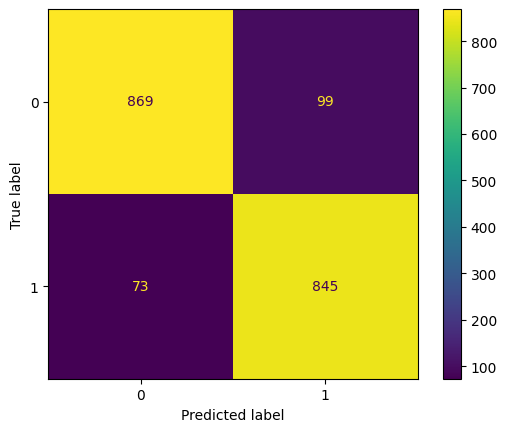

In [73]:
#LOGISTIC REGRESSION


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np



# Initialize Logistic Regression model with increased max_iter
logistic_model = LogisticRegression(max_iter=2000)  # Increase as needed

# Train the model
logistic_model.fit(xtrain, ytrain.ravel())  # Flatten ytrain if it's a column vector

# Predict on test data
y_pred = logistic_model.predict(xtest)
y_pred_proba = logistic_model.predict_proba(xtest)[:, 1]  # Probabilities for positive class

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       968
         1.0       0.97      0.99      0.98       918

    accuracy                           0.98      1886
   macro avg       0.98      0.98      0.98      1886
weighted avg       0.98      0.98      0.98      1886

AUROC Score: 0.9986636642719531
[[942  26]
 [ 10 908]]


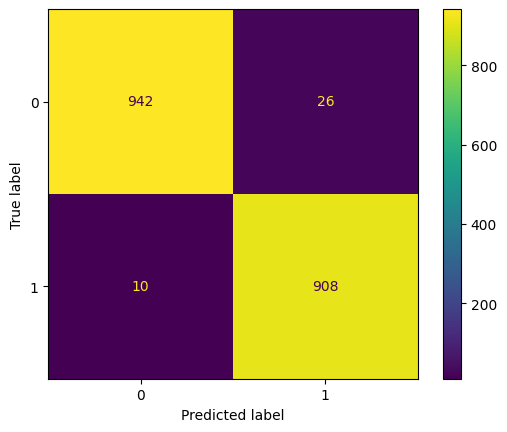

In [74]:
#RANDOM FOREST

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ... (your existing code for data preprocessing)

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed

# Train the model
rf_model.fit(xtrain, ytrain.ravel())  # Flatten ytrain if it's a column vector

# Predict on test data
y_pred = rf_model.predict(xtest)
y_pred_proba = rf_model.predict_proba(xtest)[:, 1]  # Probabilities for positive class

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       968
         1.0       0.97      0.99      0.98       918

    accuracy                           0.98      1886
   macro avg       0.98      0.98      0.98      1886
weighted avg       0.98      0.98      0.98      1886

AUROC Score: 0.999178505194548
[[940  28]
 [  6 912]]


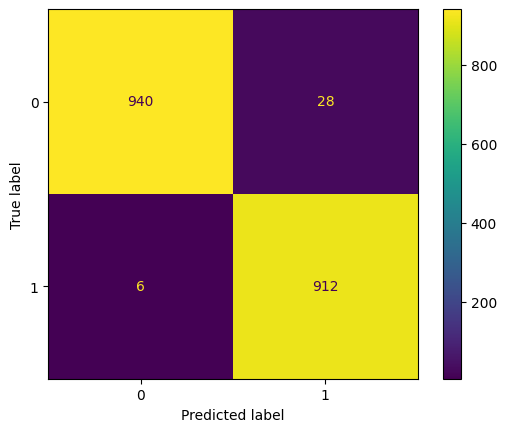

In [75]:
#XGBoost

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ... (your existing code for data preprocessing)

# Initialize XGBoost model (without use_label_encoder)
xgb_model = XGBClassifier(eval_metric='logloss')  # Adjust other parameters as needed

# Train the model
xgb_model.fit(xtrain, ytrain.ravel())  # Flatten ytrain if it's a column vector

# Predict on test data
y_pred = xgb_model.predict(xtest)
y_pred_proba = xgb_model.predict_proba(xtest)[:, 1]  # Probabilities for positive class

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [80]:
!pip install lightgbm

[LightGBM] [Info] Number of positive: 3891, number of negative: 3649
[LightGBM] [Info] Total Bins 12239
[LightGBM] [Info] Number of data points in the train set: 7540, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516048 -> initscore=0.064213
[LightGBM] [Info] Start training from score 0.064213
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       968
         1.0       0.97      0.99      0.98       918

    accuracy                           0.98      1886
   macro avg       0.98      0.98      0.98      1886
weighted avg       0.98      0.98      0.98      1886

AUROC Score: 0.9989072993752138
[[942  26]
 [  5 913]]


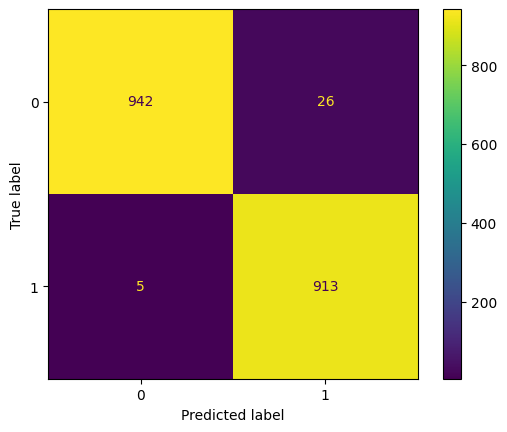

In [81]:
#LightGBM

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ... (your existing code for data preprocessing)

# Initialize LightGBM model with force_col_wise
lgb_model = LGBMClassifier(force_col_wise=True)  # Adjust other parameters as needed

# Train the model
lgb_model.fit(xtrain, ytrain.ravel())  # Flatten ytrain if it's a column vector

# Predict on test data
y_pred = lgb_model.predict(xtest)
y_pred_proba = lgb_model.predict_proba(xtest)[:, 1]  # Probabilities for positive class

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       968
         1.0       0.98      1.00      0.99       918

    accuracy                           0.99      1886
   macro avg       0.99      0.99      0.99      1886
weighted avg       0.99      0.99      0.99      1886

AUROC Score: 0.9974691207979978
[[945  23]
 [  3 915]]


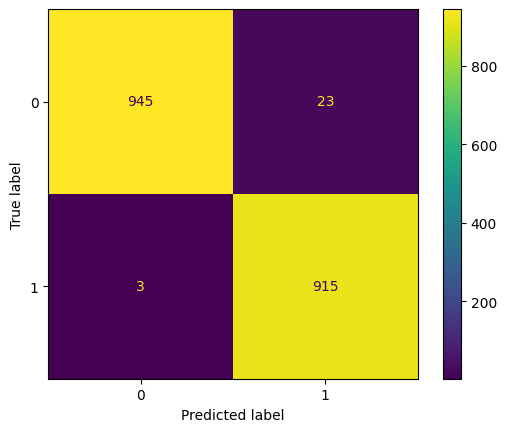

In [82]:
#MLP

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ... (your existing code for data preprocessing)

# Initialize Multi-Layer Perceptron model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=200, random_state=42)
# Adjust hidden_layer_sizes, activation, solver, max_iter, and random_state as needed

# Train the model
mlp_model.fit(xtrain, ytrain.ravel())  # Flatten ytrain if it's a column vector

# Predict on test data
y_pred = mlp_model.predict(xtest)
y_pred_proba = mlp_model.predict_proba(xtest)[:, 1]  # Probabilities for positive class

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1259 - loss: 0.5927 - val_accuracy: 0.4549 - val_loss: 0.2650
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4525 - loss: 0.2081 - val_accuracy: 0.5451 - val_loss: 0.1966
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5378 - loss: 0.1427 - val_accuracy: 0.5440 - val_loss: 0.1300
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5966 - loss: 0.1209 - val_accuracy: 0.6108 - val_loss: 0.1005
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6261 - loss: 0.0872 - val_accuracy: 0.5854 - val_loss: 0.1001
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6393 - loss: 0.0779 - val_accuracy: 0.6437 - val_loss: 0.1154
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6557 - loss: 0.0793 - val_accuracy: 0.6410 - val_loss: 0.0702
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6872 - loss: 0.0609 - val_ac

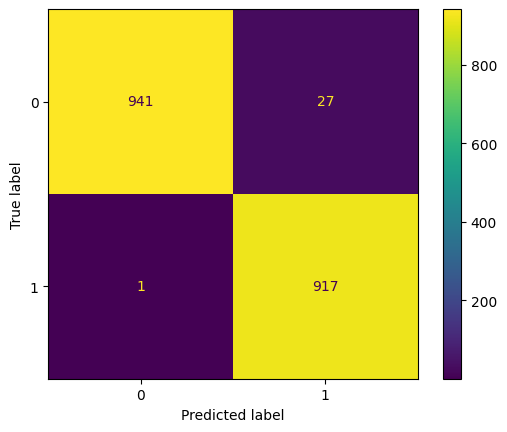

In [84]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ... (your existing code for data preprocessing)

# Define the autoencoder architecture
input_dim = xtrain.shape[1]
encoding_dim = 32  # Adjust encoding dimension as needed

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(128, activation='relu')(input_layer)
encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoder)  # Bottleneck layer

decoder = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)
decoded = tf.keras.layers.Dense(input_dim, activation='linear')(decoder)  # Reconstruction layer

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])  # Mean squared error for reconstruction loss

# Train the autoencoder
autoencoder.fit(xtrain, xtrain, epochs=100, batch_size=32, validation_data=(xtest, xtest))  # Adjust epochs and batch size

# Extract the encoded representations (latent features)
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoded)
encoded_xtrain = encoder_model.predict(xtrain)
encoded_xtest = encoder_model.predict(xtest)

# Define the classification model using encoded features
inpt = tf.keras.layers.Input(shape=(encoded_xtrain.shape[1],))
d1 = tf.keras.layers.Dense(128, activation='relu')(inpt)
d1 = tf.keras.layers.Dense(64, activation='relu')(d1)
d2 = tf.keras.layers.Dense(1, activation="sigmoid")(d1)
classifier = tf.keras.Model(inputs=inpt, outputs=d2)

# Compile the classifier
classifier.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=[tf.keras.metrics.AUC(name='auc')])

# Train the classifier
classifier.fit(encoded_xtrain, ytrain, epochs=100, batch_size=32, validation_data=(encoded_xtest, ytest))

# Predict on test data
y_pred_proba = classifier.predict(encoded_xtest)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
auc_score = roc_auc_score(ytest, y_pred_proba)
print("AUROC Score:", auc_score)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print(cm)

# Visualize the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [85]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Assuming xtrain, xtest, ytrain, ytest are already defined and preprocessed

# Reshape input data for CNN-LSTM (assuming data is tabular)
xtrain_reshaped = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xtest_reshaped = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

# Define CNN-LSTM model
input_layer = tf.keras.layers.Input(shape=(xtrain_reshaped.shape[1], 1))
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.LSTM(64)(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

# Train the model
model.fit(xtrain_reshaped, ytrain, epochs=100, batch_size=32, validation_data=(xtest_reshaped, ytest))

# Predict on test data
y_pred_proba = model.predict(xtest_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Print classification report
print(classification_report(ytest, y_pred))

# Calculate and print AUROC score
_, auc_score = model.evaluate(xtest_reshaped, ytest)
print("AUROC Score:", auc_score)

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - auc: 0.9016 - loss: 0.4010 - val_auc: 0.9733 - val_loss: 0.2943
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - auc: 0.9644 - loss: 0.2398 - val_auc: 0.9755 - val_loss: 0.2204
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - auc: 0.9726 - loss: 0.2088 - val_auc: 0.9786 - val_loss: 0.2019
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - auc: 0.9746 - loss: 0.2009 - val_auc: 0.9823 - val_loss: 0.1783
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - auc: 0.9815 - loss: 0.1722 - val_auc: 0.9807 - val_loss: 0.1950
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - auc: 0.9775 - loss: 0.1881 - val_auc: 0.9833 - val_loss: 0.1679
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - auc: 0.9833 - loss: 0.1614 - val_auc: 0.9856 - val_loss: 0.1954
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.9843 - loss: 0.1576 - val_auc: 0.9837 - val_loss: 0.1936
Epoch 9/100
236/236 ━━━━━━━━━━━━━━━━━━

Reshape Input Data: We reshape the input data to fit the expected input shape of a 1D CNN, adding a channel dimension.

CNN Layers: Two convolutional layers with max pooling extract local features from the input data.

LSTM Layer: An LSTM layer captures temporal dependencies in the extracted features.

Dense Layer: A final dense layer with sigmoid activation outputs the probability of the positive class.

Compilation: The model is compiled using binary crossentropy loss and the AUC metric.

Training: The model is trained on the reshaped training data.

Prediction: Predictions are made on the reshaped test data.

Evaluation: The classification report and AUROC score are printed to evaluate the model's performance.